## Using the discrete Fourier transform

### The fast Fourier transform (FFT)

Recall that for a sequence $\boldsymbol{f} = \{f_0, f_1, \ldots, f_{N-1}\} \in \mathbb{C}^N$ 
of sampling points
the  DFT can be written as
$$ \widehat{\boldsymbol{f}} = \mathbf{F}_N \boldsymbol{f} $$
with
$\widehat{\boldsymbol{f}} = \{\widehat{f}_0, \widehat{f}_1, \ldots, \widehat{f}_{N-1}\} \in \mathbb{C}^N$ 
where $\mathcal{F}_N$ is the (symmetric!) Fourier matrix with elements $F_{k,l} = \omega_N^{-k l}$, i.e.
$$
\mathbf{F}_N = \frac{1}{N} \begin{pmatrix}
1 & 1 & 1 & \cdots & 1 \\
1 & \omega_N^{-1} & \omega_N^{-2} & \cdots & \omega_N^{-(N-1)} \\
1 & \omega_N^{-2} & \omega_N^{-4} & \cdots & \omega_N^{-2(N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \omega_N^{-(N-1)} & \omega_N^{-2(N-1)} & \cdots & \omega_N^{-(N-1)(N-1)}
\end{pmatrix}
$$ (fou:eq:fourier_matrix)

where $\omega_N = e^{-2\pi i/N}$ is the $N$-th root of unity.

Since a naive matrix-vector multiplication has complexity $\mathcal{O}(N^2)$
(*N* row* column multiplications with *N* additions/multiplication each),
the direct computation of the DFT via its Fourier matrix becomes dramatically slow for large $N$.

Luckily, there are a lot of symmetries in the Fourier matrix that can be exploited to reduce the complexity to $\mathcal{O}(N \log N)$.
The resulting algorithm is called the
[Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) and
is considered to be among the 
*[top 10 most important algorithms](https://nhigham.com/2016/03/29/the-top-10-algorithms-in-applied-mathematics)* in applied mathematics.

While we do not have time to go into the details of the FFT algorithm, we will here reproduce (slightly modified) the
nice explanation given in {cite}`BruntonKutz2022`, Chapter 2.2.

 in particular if the number of data points $N$ is a power of 2.

The basic idea behind the FFT is that the DFT may be implemented much more efficiently if the number of data points $N$ is a power of 2.
To get an idea of how symmetries in the Fourier matrix can be exploited,  consider the case
$N=2^{10}=1024$. 
In this case, the DFT matrix $\mathbf{F}_{1024}$ may be written as

$$
\mathbf{\widehat{f}}=\mathbf{F}_{1024} \mathbf{f}=\left[\begin{array}{cc}
\mathbf{I}_{512} & \mathbf{D}_{512} \\
\mathbf{I}_{512} & -\mathbf{D}_{512}
\end{array}\right]\left[\begin{array}{cc}
\mathbf{F}_{512} & \mathbf{0} \\
\mathbf{0} & \mathbf{F}_{512}
\end{array}\right]\left[\begin{array}{c}
\mathbf{f}_{\text {even }} \\
\mathbf{f}_{\text {odd }}
\end{array}\right]
$$

where $\mathbf{f}_{\text {even }}$ are the even index elements of $\mathbf{f}, \mathbf{f}_{\text {odd }}$ are the odd index elements of $\mathbf{f}, \mathbf{I}_{512}$ is the $512 \times 512$ identity matrix, and $\mathbf{D}_{512}$ is given by

$$
\mathbf{D}_{512}=\left[\begin{array}{ccccc}
1 & 0 & 0 & \cdots & 0 \\
0 & \omega_{512} & 0 & \cdots & 0 \\
0 & 0 & \omega_{512}^{-2} & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \omega_{512}^{-511}
\end{array}\right]
$$

This expression can be derived from a careful accounting and
reorganization of the terms in the DFT matrix {eq}`fou:eq:fourier_matrix`.


If $N=2^p$, this process can be repeated, and $\mathbf{F}_{512}$ can be represented by
$\mathbf{F}_{256}$, which can then be represented by $\mathbf{F}_{128}
\rightarrow \mathbf{F}_{64} \rightarrow \mathbf{F}_{32} \rightarrow
\cdots$. If $N \neq 2^p$, the vector can be padded/filled with zeros until it
is a power of 2 . The FFT then involves an efficient interleaving of
even and odd indices of sub-vectors of $\mathbf{f}$, and the
computation of several smaller $2 \times 2$ DFT computations, with a total complexity of $\mathcal{O}(N \log N)$.

### Using the FFT in Python
Now it is time to use the FFT in Python. 
We will use the [`fft` modules from the `scipy` library](https://docs.scipy.org/doc/scipy/tutorial/fft.html), which provides a fast implementation of the FFT algorithm.
The example material below is taken and adapted from {cite}`BruntonKutz2022`, Chapter 2.2.
which the authors of the book kindly made available on [GitHub](https://github.com/dynamicslab/databook_python), specifically from the example [CH02_SEC02_2_Denoise.ipynb](https://github.com/dynamicslab/databook_python/blob/master/CH02/CH02_SEC02_2_Denoise.ipynb)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, fftshift
import pandas as pd

# plt.rcParams['figure.figsize'] = [15, 5]

Create a signal with a single

In [2]:
# Create a simple signal with two frequencies

# Interval length
L = 4*np.pi
f_clean = lambda x : np.sin(2*np.pi/L*2*x) + np.cos(2*np.pi/L*5*x) # Sum of 2 frequencies

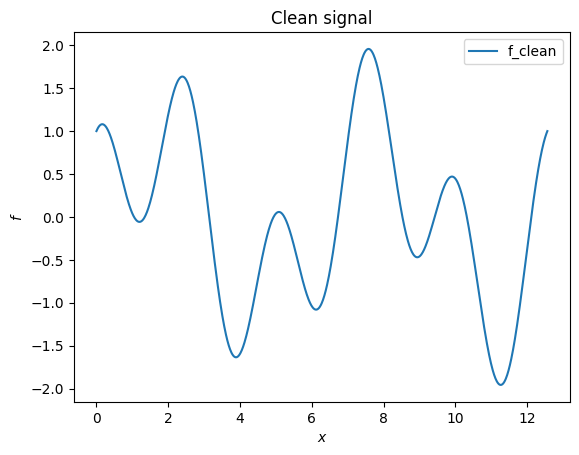

In [3]:
x = np.linspace(0, L, 1000)
plt.clf()
plt.plot(x, f_clean(x), label='f_clean')
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
plt.title('Clean signal')
plt.legend()
plt.show()

Next, we sample this signal using 100 sample points. 

:::{warning}
When sampling an supposedly periodic signal over a given domain, you have to make
sure to **exclude** the endpoint of the domain from the sampling points.
This can be achieved by using the `endpoint=False` argument in the `np.linspace` function.
Otherwise you will get rare artifacts in the Fourier transform as you basically sample the signal at the same point twice.
:::

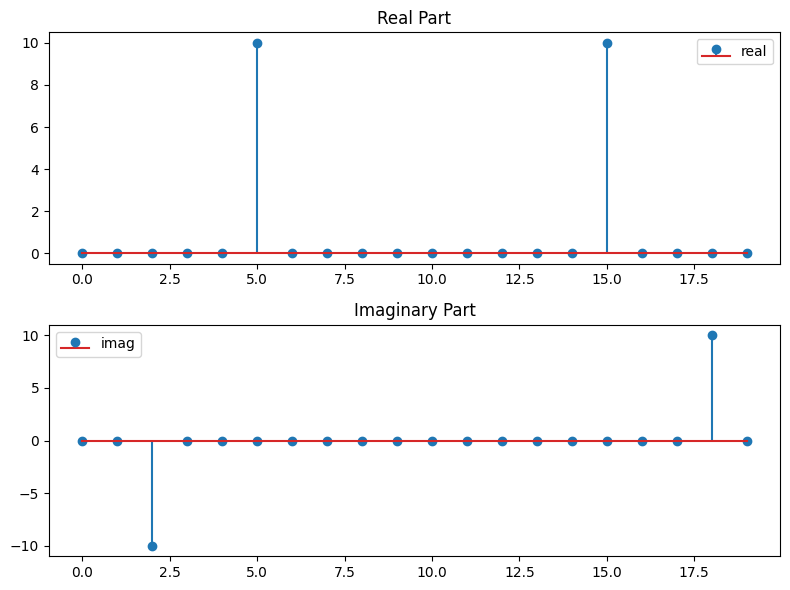

In [4]:
# Sample the signal
N = 20
xs = np.linspace(0, L, N, endpoint=False)
fcs = f_clean(xs)

fcs_hat = fft(fcs)
fig = plt.figure(figsize=(8, 6))
axs = fig.subplots(2, 1)
axs[0].stem(fcs_hat.real, label='real')
axs[0].set_title('Real Part')
axs[0].legend()

axs[1].stem(fcs_hat.imag, label='imag')
axs[1].set_title('Imaginary Part')
axs[1].legend()
plt.tight_layout()

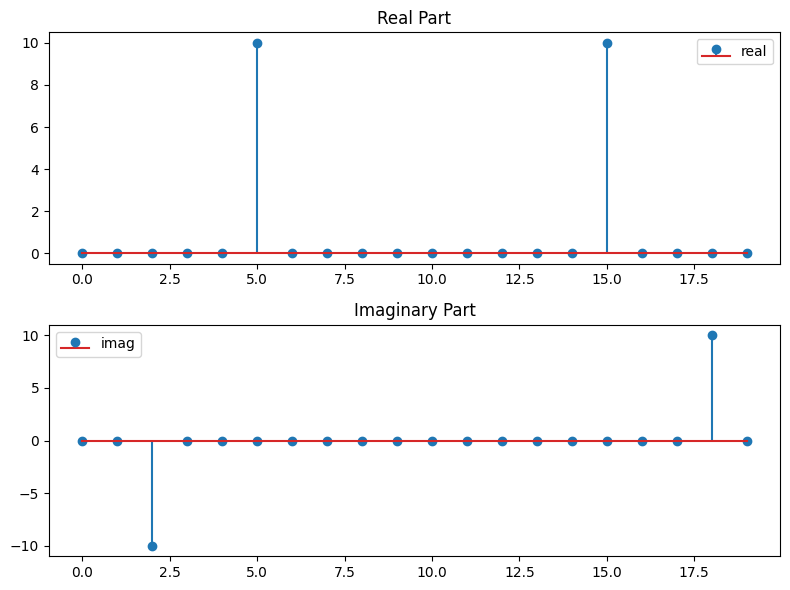

In [5]:
# Sample the signal
N = 20
xs = np.linspace(0, L, N, endpoint=False)
fcs = f_clean(xs)

fcs_hat = fft(fcs)
fig = plt.figure(figsize=(8, 6))
axs = fig.subplots(2, 1)
axs[0].stem(fcs_hat.real, label='real')
axs[0].set_title('Real Part')
axs[0].legend()

axs[1].stem(fcs_hat.imag, label='imag')
axs[1].set_title('Imaginary Part')
axs[1].legend()
plt.tight_layout()

Ok, let's try to understand this plot a bit better.
First, we need to recall the ordering of the FFT output as discussed in
{ref}`sec:triginterp`:

For $N = 2n +1 $ we have

\begin{align}
[\widehat{f}_0, \widehat{f}_1, \ldots, \widehat{f}_{n}, \widehat{f}_{-n}, \ldots, \widehat{f}_{-1}]
\end{align}
while for  $N = 2n$ we have instead the order
\begin{align}
 [\widehat{f}_0, \widehat{f}_1, \ldots, \widehat{f}_{n-1}, \widehat{f}_{-n}, \ldots, \widehat{f}_{-1}]
\end{align}
Thus we need to shift the output of the FFT accordingly to get the correct ordering.
This can be done using the [`fftshift` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftshift.html#scipy.fft.fftshift) from the `scipy.fft` module.

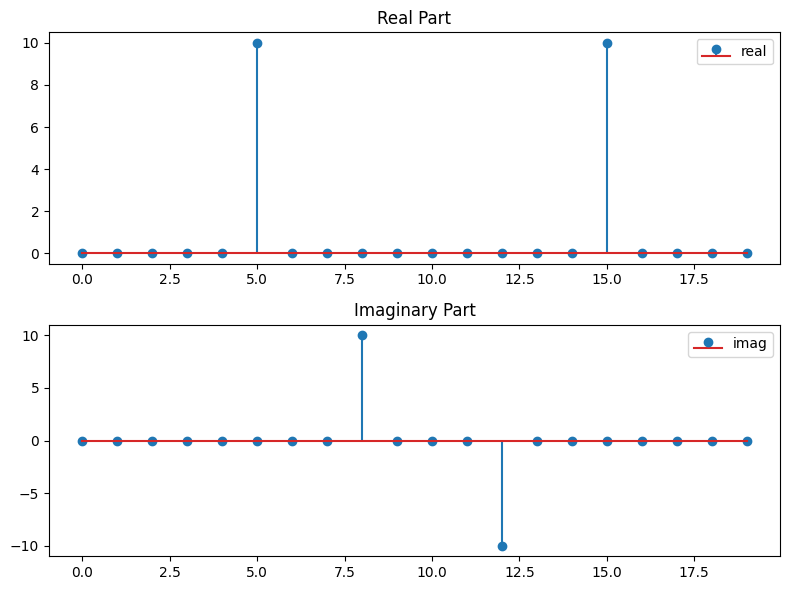

In [6]:
# Sample the signal
N = 20
xs = np.linspace(0, L, N, endpoint=False)
fcs = f_clean(xs)

fcs_hat_shift = fftshift(fcs_hat)
fig = plt.figure(figsize=(8, 6))
axs = fig.subplots(2, 1)
axs[0].stem(fcs_hat_shift.real, label='real')
axs[0].set_title('Real Part')
axs[0].legend()

axs[1].stem(fcs_hat_shift.imag, label='imag')
axs[1].set_title('Imaginary Part')
axs[1].legend()
plt.tight_layout()

This makes now almost sense :) but right now the $x$-axis is just the index of the array. It would be nice to adapt the $x$-axis to the frequency.
We can easily obtain the relevant frequencies by using the [`fftfreq` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq) from the `scipy.fft` module.

The `fftfreq` function takes as input the number of sample points and the spacing between the sample points and returns the Discrete Fourier Transform sample frequencies.
More precisely, it returns
```python   
f = [0, 1, ...,   N/2-1,     -N/2, ..., -1] / (d*N)   if N is even
f = [0, 1, ..., (N-1)/2, -(N-1)/2, ..., -1] / (d*N)   if N is odd
```
So in order obtain the **sampling frequencies**, we need to multiply the output of `fftfreq` by the length `d*N` the the interval over which we sampled the signal:

In [7]:
freqs = fftfreq(N) # Assumes a sampling width of d = 1  
print(freqs)

[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45 -0.5  -0.45
 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05]


In [8]:
freqs = fftfreq(N, d=1/N)
print(freqs)
# Equivalent to
freqs = np.fft.fftfreq(N, d=L/N)*L
print(freqs)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.]
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9. -10.  -9.  -8.  -7.
  -6.  -5.  -4.  -3.  -2.  -1.]


This might not look exactly as the frequencies we expected for $N$ samples, does it?
Note for the fundamental frequency $f_0$ is given by $f_0 = 2\pi/L$ where $T$ is the total time spanned by the signal.

So know we can plot the signal and its Fourier transform in a single plot.
But before we again have to shift the frequencies to the correct order.

In [9]:
freqs_shift = fftshift(fftfreq(N, d=1/N))
print(freqs_shift)

[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.]


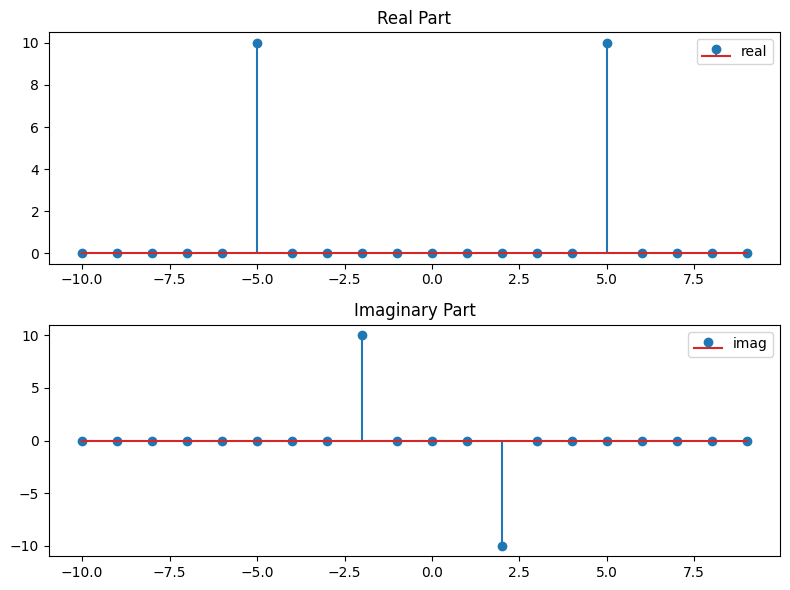

In [10]:
fig = plt.figure(figsize=(8, 6))
axs = fig.subplots(2, 1)
axs[0].stem(freqs_shift, fcs_hat_shift.real, label='real')
axs[0].set_title('Real Part')
axs[0].legend()

axs[1].stem(freqs_shift, fcs_hat_shift.imag, label='imag')
axs[1].set_title('Imaginary Part')
axs[1].legend()
plt.tight_layout()

Note the hight of the peaks in the Fourier transform plot
and recall that the the `fft` functions return the Fourier coefficients which are not normalized by the number of sample points. If we divide by $N$ we get the correct amplitudes of the Fourier coefficients, which should $1/2$ for
a $\cos(2\pi k/L x)$ or $\sin(2\pi k/L x)$ type of signal.

### Aliasing and Nyquist frequency

To the previous signal we add a high frequency component to the signal and sample it again 
with the same sampling rate as before.

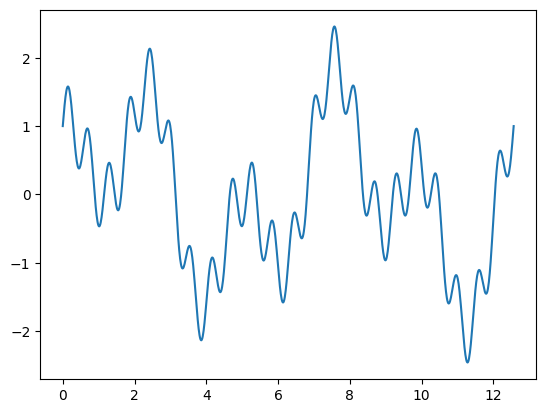

In [11]:
# For N = 20
N=20
f_alias = lambda x :  0.5*np.sin((2+20)*np.pi/L*2*x) + f_clean(x) 

plt.figure()
plt.plot(x, f_alias(x), label='f_alias')
plt.show()

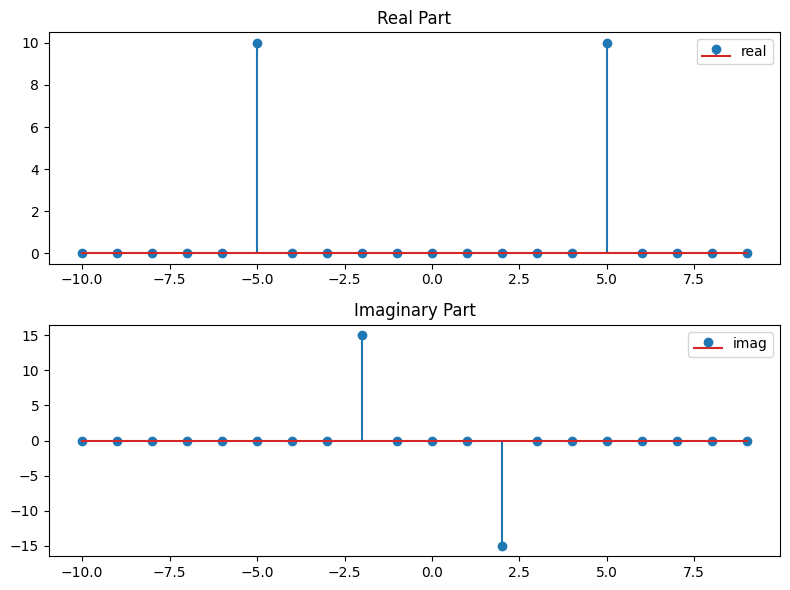

In [12]:
f_alias_shift = fftshift(fft(f_alias(xs)))

fig = plt.figure(figsize=(8, 6))
axs = fig.subplots(2, 1)
axs[0].stem(freqs_shift, f_alias_shift.real, label='real')
axs[0].set_title('Real Part')
axs[0].legend()

axs[1].stem(freqs_shift, f_alias_shift.imag, label='imag')
axs[1].set_title('Imaginary Part')
axs[1].legend()
plt.tight_layout()

We note that we get the same frequencies as for the original clean signal, but the amplitude for the imaginary part is different, namely 1.5 of the original signal.
The reason for that boils down to the 
previously stated orthogonality properties of the trigonometric functions
with respect to the discrete inner product:

$$
\langle \omega^l, \omega^m \rangle_N 
=
\begin{cases}
1 & \text{if } (l-m)/N \in \mathbb{Z}, \\
0 & \text{else.}
\end{cases}
$$

In particular that means, that $\omega^l$ and $\omega^{l+N}$  cannot be distinguished for a sampling number of $N$. 
In other words, $\omega^{l+N}$ is an **alias** of $\omega^l$.
This is known as **aliasing** and is a common problem in signal processing.

In our concrete example, the function
$\sin(2\pi/L 2x)$ and
and
$0.5\sin((2+20)\pi/L 2x)$ were indistinguishable for the sampling rate of $N=20$
and thus they appear as the same frequency in the Fourier transform
with the amplitudes added.

It can be shown that for signals with a maximal frequency of $p$, aliasing
can be avoided if the sampling rate $> 2p$. This is called the
**Nyquist frequency**.

So let's increase the sampling rate to $N=2\cdot 22+1 = 45$ and sample the signal again.

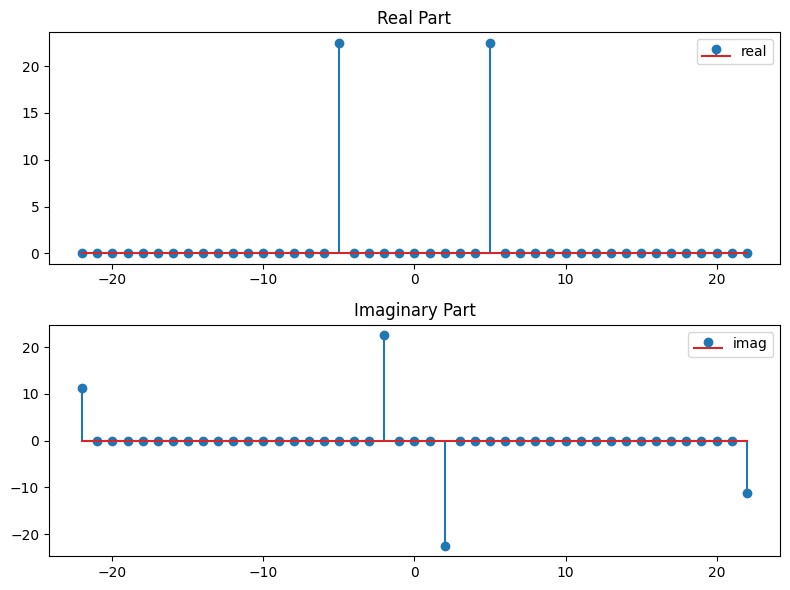

In [13]:
# Sample the signal
N = 45
xs = np.linspace(0, L, N, endpoint=False)
f_alias_shift = fftshift(fft(f_alias(xs)))
freqs_shift = fftshift(fftfreq(N, d=1/N))

fig = plt.figure(figsize=(8, 6))
axs = fig.subplots(2, 1)
axs[0].stem(freqs_shift, f_alias_shift.real, label='real')
axs[0].set_title('Real Part')
axs[0].legend()

axs[1].stem(freqs_shift, f_alias_shift.imag, label='imag')
axs[1].set_title('Imaginary Part')
axs[1].legend()
plt.tight_layout()